In [1]:
from pathlib import Path
import pandas as pd
from PIL import Image
import logging

In [2]:
logger = logging.getLogger(__name__)

In [3]:
IMAGE_INDEX_PATH = "../data/index.csv"
IMAGES_FOLDER_PATH = "../data/images"

In [4]:
image_index_df = pd.read_csv(IMAGE_INDEX_PATH)
image_index_df.head()

,url,id
0,https://c4.staticflickr.com/9/8555/15625756039...,461828
1,https://farm8.staticflickr.com/7214/7337479734...,165352
2,https://farm2.staticflickr.com/3299/3509371657...,224667
3,https://c4.staticflickr.com/1/52/129983132_b66...,602094
4,https://c4.staticflickr.com/1/55/155642663_7e2...,347895


In [5]:
len(image_index_df)

295

In [6]:
IMAGES = image_index_df.set_index("id").to_dict(orient="index")

for index in IMAGES:
    filepath = Path(IMAGES_FOLDER_PATH, IMAGES[index]["url"].split("/")[-1])
    
    if not filepath.exists():
        logging.warning(f"File {filepath} doesn't exist")
    
    IMAGES[index]["filepath"] = filepath

In [7]:
from collections import Counter

shapes = []

for index in IMAGES:
    try:
        image = Image.open(IMAGES[index]["filepath"])
        shapes.append(image.size)
    except Exception as e:
        print(index, e)

Counter(shapes)

515274 cannot identify image file '/home/rperrier/wdir/lydia/data/images/5537502948_503ea812fb_o.jpg'
75680 cannot identify image file '/home/rperrier/wdir/lydia/data/images/406453588_b2541371b8_o.jpg'
107133 cannot identify image file '/home/rperrier/wdir/lydia/data/images/7805590320_6a55e048c2_o.jpg'


Counter({(800, 600): 15,
         (612, 612): 14,
         (640, 640): 11,
         (1024, 768): 9,
         (640, 480): 9,
         (1600, 1200): 8,
         (2048, 1536): 6,
         (600, 800): 6,
         (1200, 1600): 6,
         (2592, 1944): 5,
         (960, 1280): 5,
         (1280, 960): 4,
         (360, 480): 3,
         (768, 1024): 3,
         (1600, 1066): 3,
         (800, 533): 3,
         (827, 549): 2,
         (720, 960): 2,
         (500, 500): 2,
         (1024, 1024): 2,
         (2500, 1656): 2,
         (1024, 683): 2,
         (3872, 2592): 2,
         (1224, 814): 1,
         (2590, 2160): 1,
         (768, 747): 1,
         (985, 1024): 1,
         (800, 569): 1,
         (1024, 682): 1,
         (1011, 1024): 1,
         (341, 301): 1,
         (1026, 684): 1,
         (1600, 1223): 1,
         (900, 600): 1,
         (1500, 1125): 1,
         (960, 720): 1,
         (372, 280): 1,
         (800, 530): 1,
         (956, 959): 1,
         (1363, 1973): 1,
  

3 images can't be load, manual verification -> empty files  
origin : the download script create the file before making the request, if request failed the file stays empty.

In [8]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load a pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Remove the final classification layer to get features
model = torch.nn.Sequential(*list(model.children())[:-1])

# Set the model to evaluation mode
model.eval()

# Function to preprocess the image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image

# Function to get the image embedding
def get_image_embedding(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        embedding = model(image)
    return embedding.squeeze().numpy()

# Example usage
image_path = IMAGES[461828]["filepath"]
embedding = get_image_embedding(image_path)
print(embedding)


[0.00828178 0.         0.00035485 ... 0.         0.04880304 0.        ]


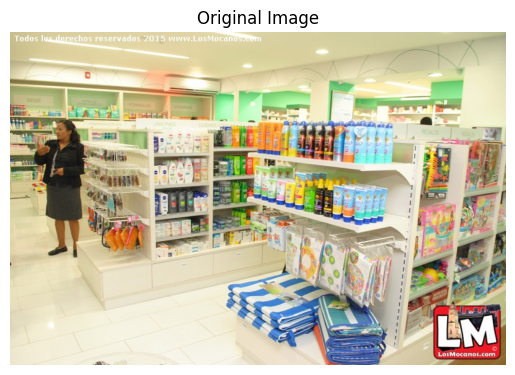

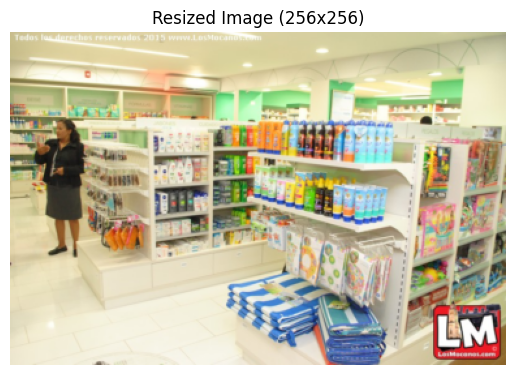

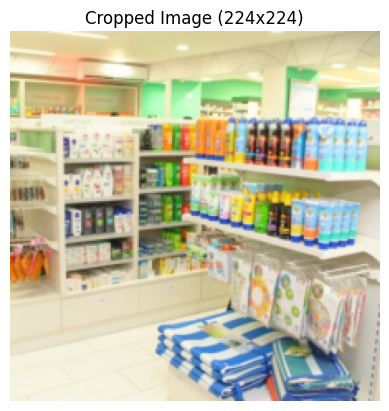

In [9]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Load the image
image_path = IMAGES[202613]["filepath"]
original_image = Image.open(image_path)

# Define preprocessing steps
resize_transform = transforms.Resize(256)
crop_transform = transforms.CenterCrop(224)
to_tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Apply each step and display the result
resized_image = resize_transform(original_image)
cropped_image = crop_transform(resized_image)
tensor_image = to_tensor_transform(cropped_image)
# Normalize transform cannot be visualized directly, so we skip displaying it

# Display images
def display_image(image, title):
    plt.figure()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display the images after each preprocessing step
display_image(original_image, "Original Image")
display_image(resized_image, "Resized Image (256x256)")
display_image(cropped_image, "Cropped Image (224x224)")